<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Augmenting_convnets_with_aggregated_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Augmenting convnets with aggregated attention**

## Introduction

Vision transformers ([Dosovitskiy et. al](https://arxiv.org/abs/2010.11929))
have emerged as a powerful alternative to Convolutional Neural Networks.
ViTs process the images in a patch-based manner. The image information
is then aggregated into a `CLASS` token. This token correlates to the
most important patches of the image for a particular classification decision.

The interaction between the `CLASS` token and the patches can be visualized
to help explain a classification decision. In the academic paper
[Augmenting convolutional networks with attention-based aggregation](https://arxiv.org/abs/2112.13692)
by Touvron et. al, the authors propose to set up an equivalent visualization for
convnets. They propose to substitute the global average pooling layer
of a convnet with a Transformer layer. The self-attention layer of the
Transformer would produce attention maps that correspond to the
most attended patches of the image for the classification decision.

In this example, we minimally implement the ideas of
[Augmenting Convolutional networks with attention-based aggregation](https://arxiv.org/abs/2112.13692).
The main goal of this example is to cover the following ideas, with
minor modifications (to adjust the implementation with CIFAR10):

- The simple design for the attention-based pooling layer, such that
    it explicitly provides the weights (importance) of the different
    patches.
- The novel architecture of convnet is called the **PatchConvNet** which
    deviates from the age old pyramidal architecture.

In [ ]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.7 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers

# Set seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# DATA
BATCH_SIZE = 128
BUFFER_SIZE = BATCH_SIZE * 2
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10  # for CIFAR 10

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size.

# ARCHITECTURE
DIMENSIONS = 256
SE_RATIO = 8
TRUNK_DEPTH = 2

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 50

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val)   = (
        (x_train[:40000], y_train[:40000]),
        (x_train[40000:], y_train[40000:]))


print(len(x_train))
print(len(x_test))
print(len(x_val))

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

170498071/170498071 [==============================] - 13s 0us/step
40000
10000
10000


In [ ]:
def get_preprocessing():
    model = keras.Sequential(
        [
            layers.Rescaling(1.0 / 255.0),
            layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)
        ], name = "preprocessing")
    return model


def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model

## Convolutional stem

The stem of the model is a lightweight preprocessing module that
maps images pixels to a set of vectors (patches).

In [ ]:
def build_convolutional_stem(dimensions):
    """Build the convolutional stem.

    Args:
        dimensions: The embedding dimension of the patches (d in paper).

    Returs:
        The convolutional stem as a keras seqeuntial
        model.
    """
    config = {
        "kernel_size": (3, 3),
        "strides": (2, 2),
        "activation": tf.nn.gelu,
        "padding": "same",
    }

    convolutional_stem = keras.Sequential(
        [
            layers.Conv2D(filters=dimensions // 2, **config),
            layers.Conv2D(filters=dimensions, **config),
        ],
        name="convolutional_stem",
    )

    return convolutional_stem

## Convolutional trunk

The trunk of the model is the most compute-intesive part. It consists
of `N` stacked residual convolutional blocks.

In [ ]:
class SqueezeExcite(layers.Layer):
    """Applies squeeze and excitation to input feature maps as seen in
    https://arxiv.org/abs/1709.01507.

    Args:
        ratio: The ratio with which the feature map needs to be reduced in
        the reduction phase.

    Inputs:
        Convolutional features.

    Outputs:
        Attention modified feature maps.
    """

    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio, activation="relu", use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x


class Trunk(layers.Layer):
    """Convolutional residual trunk as in the https://arxiv.org/abs/2112.13692

    Args:
        depth: Number of trunk residual blocks
        dimensions: Dimnesion of the model (denoted by d in the paper)
        ratio: The Squeeze-Excitation ratio

    Inputs:
        Convolutional features extracted from the conv stem.

    Outputs:
        Flattened patches.
    """

    def __init__(self, depth, dimensions, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
        self.dimensions = dimensions
        self.depth = depth

    def get_config(self):
        config = super().get_config()
        config.update(
            {"ratio": self.ratio, "dimensions": self.dimensions, "depth": self.depth,}
        )
        return config

    def build(self, input_shape):
        config = {
            "filters": self.dimensions,
            "activation": tf.nn.gelu,
            "padding": "same",
        }

        trunk_block = [
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(kernel_size=(1, 1), **config),
            layers.Conv2D(kernel_size=(3, 3), **config),
            SqueezeExcite(ratio=self.ratio),
            layers.Conv2D(kernel_size=(1, 1), filters=self.dimensions, padding="same"),
        ]

        self.trunk_blocks = [keras.Sequential(trunk_block) for _ in range(self.depth)]
        self.add = layers.Add()
        self.flatten_spatial = layers.Reshape((-1, self.dimensions))

    def call(self, x):
        # Remember the input.
        shortcut = x
        for trunk_block in self.trunk_blocks:
            output = trunk_block(x)
            shortcut = self.add([output, shortcut])
            x = shortcut
        # Flatten the patches.
        x = self.flatten_spatial(x)
        return x

## Attention Pooling

The output of the convolutional trunk is attended with a trainable
_query_ class token. The resulting attention map is the weight of
every patch of the image for a classification decision.

In [ ]:
class AttentionPooling(layers.Layer):
    """Applies attention to the patches extracted form the
    trunk with the CLS token.

    Args:
        dimensions: The dimension of the whole architecture.
        num_classes: The number of classes in the dataset.

    Inputs:
        Flattened patches from the trunk.

    Outputs:
        The modifies CLS token.
    """

    def __init__(self, dimensions, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dimensions = dimensions
        self.num_classes = num_classes
        self.cls = tf.Variable(tf.zeros((1, 1, dimensions)))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "dimensions": self.dimensions,
                "num_classes": self.num_classes,
                "cls": self.cls.numpy(),
            }
        )
        return config

    def build(self, input_shape):
        self.attention = layers.MultiHeadAttention(
            num_heads=1, key_dim=self.dimensions, dropout=0.2,
        )
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential(
            [
                layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
                layers.Dropout(0.2),
                layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
            ]
        )
        self.dense = layers.Dense(units=self.num_classes)
        self.flatten = layers.Flatten()

    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Expand the class token batch number of times.
        class_token = tf.repeat(self.cls, repeats=batch_size, axis=0)
        # Concat the input with the trainable class token.
        x = tf.concat([class_token, x], axis=1)
        # Apply attention to x.
        x = self.layer_norm1(x)
        x, viz_weights = self.attention(
            query=x[:, 0:1], key=x, value=x, return_attention_scores=True
        )
        class_token = class_token + x
        class_token = self.layer_norm2(class_token)
        class_token = self.flatten(class_token)
        class_token = self.layer_norm3(class_token)
        class_token = class_token + self.mlp(class_token)
        # Build the logits
        logits = self.dense(class_token)
        return logits, tf.squeeze(viz_weights)[..., 1:]

## Patch convnet

The patch-convnet is shown in the figure below.

| ![image model](https://i.imgur.com/NHiQeac.png) |
| :--: |
| [Source](https://arxiv.org/abs/2112.13692) |

All the modules in the architecture are built in the earlier seciton.
In this section, we stack all of the different modules together.

In [ ]:
class PatchConvNet(keras.Model):
    def __init__(
        self,
        stem,
        trunk,
        attention_pooling,
        preprocessing_model,
        train_augmentation_model,
        **kwargs):

        super().__init__(**kwargs)
        self.stem = stem
        self.trunk = trunk
        self.attention_pooling = attention_pooling
        self.train_augmentation_model = train_augmentation_model
        self.preprocessing_model = preprocessing_model

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "stem": self.stem,
                "trunk": self.trunk,
                "attention_pooling": self.attention_pooling,
                "train_augmentation_model": self.train_augmentation_model,
                "preprocessing_model": self.preprocessing_model,
            }
        )
        return config

    def _calculate_loss(self, inputs, test=False):
        images, labels = inputs
        # Augment the input images.
        if test:
            augmented_images = self.preprocessing_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, _ = self.attention_pooling(x)
        # Compute the total loss.
        total_loss = self.compiled_loss(labels, logits)
        return total_loss, logits

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            total_loss, logits = self._calculate_loss(inputs)
        # Apply gradients.
        train_vars = [
            self.stem.trainable_variables,
            self.trunk.trainable_variables,
            self.attention_pooling.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        trainable_variable_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                trainable_variable_list.append((g, v))
        self.optimizer.apply_gradients(trainable_variable_list)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        total_loss, logits = self._calculate_loss(inputs, test=True)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def call(self, images):
        # Augment the input images.
        augmented_images = self.preprocessing_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, viz_weights = self.attention_pooling(x)
        return logits, viz_weights

## Callbacks

This callback will plot the image and the attention map overlayed on
the image.

In [ ]:
# Taking a batch of test inputs to measure model's progress.
test_images, test_labels = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 4:
            test_augmented_images = self.model.preprocessing_model(test_images)
            # Pass through the stem.
            test_x = self.model.stem(test_augmented_images)
            # Pass through the trunk.
            test_x = self.model.trunk(test_x)
            # Pass through the attention pooling block.
            _, test_viz_weights = self.model.attention_pooling(test_x)
            # Reshape the vizualization weights
            num_patches = tf.shape(test_viz_weights)[-1]
            height = width = int(math.sqrt(num_patches))
            test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
            # Take a random image and its attention weights.
            index = np.random.randint(low=0, high=tf.shape(test_augmented_images)[0])
            selected_image = test_augmented_images[index]
            selected_weight = test_viz_weights[index]
            # Plot the images and the overlayed attention map.
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            ax[0].imshow(selected_image)
            ax[0].set_title(f"Original: {epoch:03d}")
            ax[0].axis("off")
            img = ax[1].imshow(selected_image)
            ax[1].imshow(
                selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent()
            )
            ax[1].set_title(f"Attended: {epoch:03d}")
            ax[1].axis("off")
            plt.axis("off")
            plt.show()
            plt.close()

## Learning rate schedule

In [ ]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

## Training

We build the model, compile it, and train it.

Epoch 1/50
  6/313 [..............................] - ETA: 29s - loss: 2.3983 - accuracy: 0.1198 - top-5-accuracy: 0.5052

313/313 [==============================] - 50s 108ms/step - loss: 1.9220 - accuracy: 0.2749 - top-5-accuracy: 0.7946 - val_loss: 1.7846 - val_accuracy: 0.3688 - val_top-5-accuracy: 0.8403
Epoch 2/50
313/313 [==============================] - 33s 106ms/step - loss: 1.5207 - accuracy: 0.4342 - top-5-accuracy: 0.9117 - val_loss: 1.3816 - val_accuracy: 0.4849 - val_top-5-accuracy: 0.9373
Epoch 3/50
313/313 [==============================] - 33s 106ms/step - loss: 1.3189 - accuracy: 0.5165 - top-5-accuracy: 0.9385 - val_loss: 1.2991 - val_accuracy: 0.5342 - val_top-5-accuracy: 0.9408
Epoch 4/50
313/313 [==============================] - 33s 105ms/step - loss: 1.1641 - accuracy: 0.5840 - top-5-accuracy: 0.9546 - val_loss: 1.0756 - val_accuracy: 0.6143 - val_top-5-accuracy: 0.9581
Epoch 5/50
313/313 [==============================] - ETA: 0s - loss: 1.0340 - accuracy: 0.6287 - top-5-accuracy: 0.9650

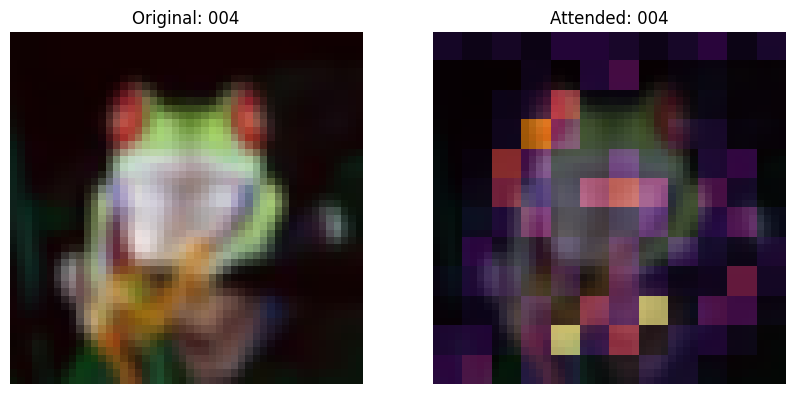

313/313 [==============================] - 33s 106ms/step - loss: 1.0340 - accuracy: 0.6287 - top-5-accuracy: 0.9650 - val_loss: 1.0214 - val_accuracy: 0.6380 - val_top-5-accuracy: 0.9646
Epoch 6/50
313/313 [==============================] - 33s 105ms/step - loss: 0.9186 - accuracy: 0.6755 - top-5-accuracy: 0.9739 - val_loss: 0.9957 - val_accuracy: 0.6522 - val_top-5-accuracy: 0.9662
Epoch 7/50
313/313 [==============================] - 33s 105ms/step - loss: 0.8266 - accuracy: 0.7091 - top-5-accuracy: 0.9780 - val_loss: 0.8105 - val_accuracy: 0.7139 - val_top-5-accuracy: 0.9776
Epoch 8/50
313/313 [==============================] - 35s 110ms/step - loss: 0.7492 - accuracy: 0.7357 - top-5-accuracy: 0.9833 - val_loss: 0.7851 - val_accuracy: 0.7233 - val_top-5-accuracy: 0.9807
Epoch 9/50
313/313 [==============================] - 33s 105ms/step - loss: 0.6859 - accuracy: 0.7597 - top-5-accuracy: 0.9862 - val_loss: 0.7349 - val_accuracy: 0.7480 - val_top-5-accuracy: 0.9823
Epoch 10/50
313/

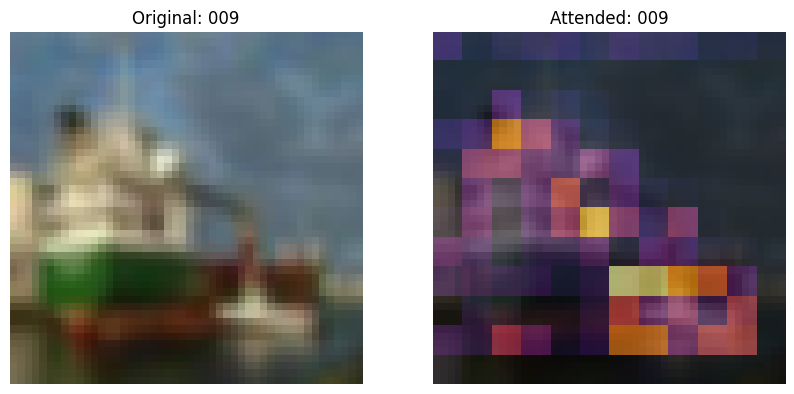

313/313 [==============================] - 34s 107ms/step - loss: 0.6319 - accuracy: 0.7815 - top-5-accuracy: 0.9875 - val_loss: 0.6747 - val_accuracy: 0.7688 - val_top-5-accuracy: 0.9851
Epoch 11/50
313/313 [==============================] - 33s 105ms/step - loss: 0.5851 - accuracy: 0.7974 - top-5-accuracy: 0.9895 - val_loss: 0.8399 - val_accuracy: 0.7314 - val_top-5-accuracy: 0.9775
Epoch 12/50
313/313 [==============================] - 33s 107ms/step - loss: 0.5592 - accuracy: 0.8062 - top-5-accuracy: 0.9905 - val_loss: 0.6206 - val_accuracy: 0.7889 - val_top-5-accuracy: 0.9869
Epoch 13/50
313/313 [==============================] - 33s 105ms/step - loss: 0.5315 - accuracy: 0.8169 - top-5-accuracy: 0.9910 - val_loss: 0.6452 - val_accuracy: 0.7882 - val_top-5-accuracy: 0.9855
Epoch 14/50
313/313 [==============================] - 33s 106ms/step - loss: 0.4970 - accuracy: 0.8264 - top-5-accuracy: 0.9928 - val_loss: 0.6032 - val_accuracy: 0.7960 - val_top-5-accuracy: 0.9884
Epoch 15/50


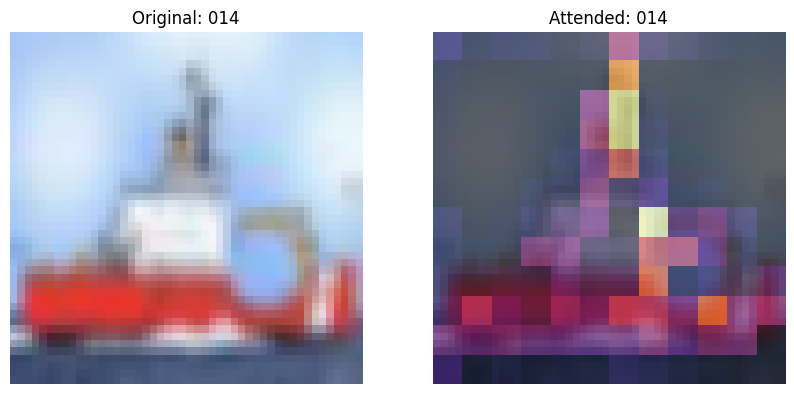

313/313 [==============================] - 33s 106ms/step - loss: 0.4724 - accuracy: 0.8356 - top-5-accuracy: 0.9934 - val_loss: 0.5678 - val_accuracy: 0.8047 - val_top-5-accuracy: 0.9898
Epoch 16/50
313/313 [==============================] - 33s 105ms/step - loss: 0.4664 - accuracy: 0.8379 - top-5-accuracy: 0.9937 - val_loss: 0.5824 - val_accuracy: 0.8027 - val_top-5-accuracy: 0.9880
Epoch 17/50
313/313 [==============================] - 33s 105ms/step - loss: 0.4437 - accuracy: 0.8453 - top-5-accuracy: 0.9947 - val_loss: 0.5700 - val_accuracy: 0.8087 - val_top-5-accuracy: 0.9895
Epoch 18/50
313/313 [==============================] - 33s 106ms/step - loss: 0.4142 - accuracy: 0.8550 - top-5-accuracy: 0.9954 - val_loss: 0.5325 - val_accuracy: 0.8188 - val_top-5-accuracy: 0.9908
Epoch 19/50
313/313 [==============================] - 33s 106ms/step - loss: 0.3957 - accuracy: 0.8641 - top-5-accuracy: 0.9955 - val_loss: 0.5248 - val_accuracy: 0.8205 - val_top-5-accuracy: 0.9907
Epoch 20/50


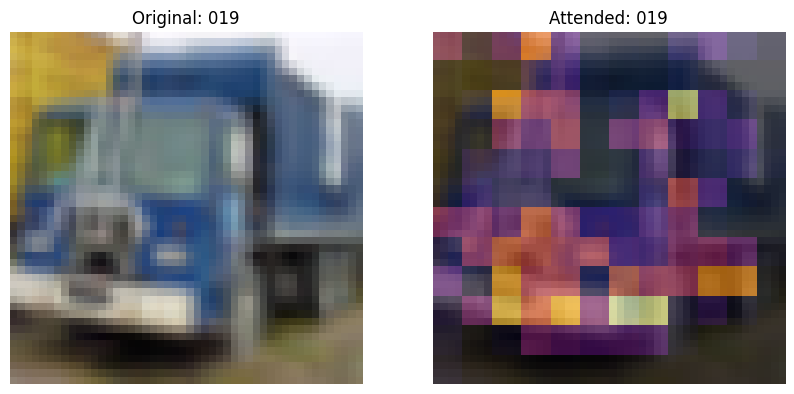

313/313 [==============================] - 34s 107ms/step - loss: 0.3810 - accuracy: 0.8677 - top-5-accuracy: 0.9955 - val_loss: 0.5908 - val_accuracy: 0.8029 - val_top-5-accuracy: 0.9860
Epoch 21/50
313/313 [==============================] - 33s 105ms/step - loss: 0.3682 - accuracy: 0.8709 - top-5-accuracy: 0.9963 - val_loss: 0.5785 - val_accuracy: 0.8055 - val_top-5-accuracy: 0.9893
Epoch 22/50
313/313 [==============================] - 33s 106ms/step - loss: 0.3463 - accuracy: 0.8807 - top-5-accuracy: 0.9967 - val_loss: 0.5437 - val_accuracy: 0.8215 - val_top-5-accuracy: 0.9907
Epoch 23/50
313/313 [==============================] - 33s 105ms/step - loss: 0.3238 - accuracy: 0.8877 - top-5-accuracy: 0.9971 - val_loss: 0.5195 - val_accuracy: 0.8277 - val_top-5-accuracy: 0.9901
Epoch 24/50
313/313 [==============================] - 33s 105ms/step - loss: 0.3111 - accuracy: 0.8929 - top-5-accuracy: 0.9975 - val_loss: 0.5197 - val_accuracy: 0.8308 - val_top-5-accuracy: 0.9911
Epoch 25/50


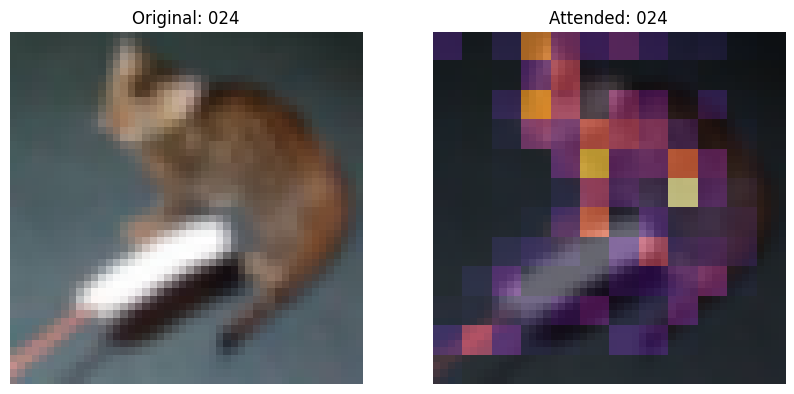

313/313 [==============================] - 33s 106ms/step - loss: 0.2982 - accuracy: 0.8979 - top-5-accuracy: 0.9977 - val_loss: 0.5368 - val_accuracy: 0.8238 - val_top-5-accuracy: 0.9911
Epoch 26/50
313/313 [==============================] - 33s 106ms/step - loss: 0.2728 - accuracy: 0.9057 - top-5-accuracy: 0.9980 - val_loss: 0.5255 - val_accuracy: 0.8317 - val_top-5-accuracy: 0.9913
Epoch 27/50
313/313 [==============================] - 33s 106ms/step - loss: 0.2656 - accuracy: 0.9085 - top-5-accuracy: 0.9982 - val_loss: 0.4877 - val_accuracy: 0.8405 - val_top-5-accuracy: 0.9920
Epoch 28/50
313/313 [==============================] - 33s 105ms/step - loss: 0.2428 - accuracy: 0.9166 - top-5-accuracy: 0.9985 - val_loss: 0.4847 - val_accuracy: 0.8467 - val_top-5-accuracy: 0.9923
Epoch 29/50
313/313 [==============================] - 33s 106ms/step - loss: 0.2321 - accuracy: 0.9184 - top-5-accuracy: 0.9985 - val_loss: 0.4985 - val_accuracy: 0.8488 - val_top-5-accuracy: 0.9923
Epoch 30/50


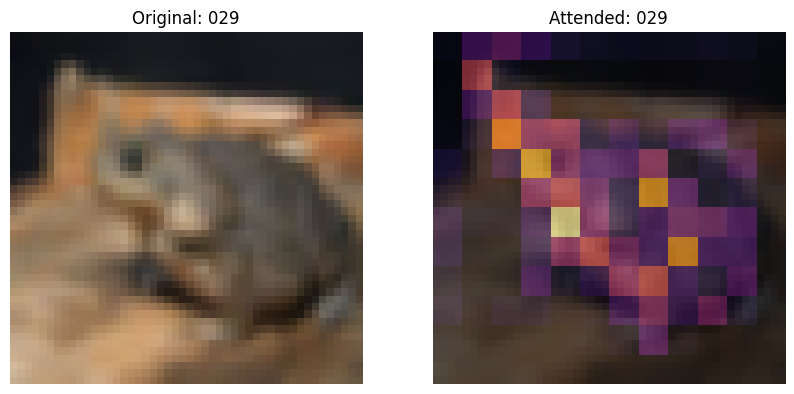

313/313 [==============================] - 33s 106ms/step - loss: 0.2137 - accuracy: 0.9255 - top-5-accuracy: 0.9992 - val_loss: 0.5025 - val_accuracy: 0.8445 - val_top-5-accuracy: 0.9920
Epoch 31/50
313/313 [==============================] - 33s 106ms/step - loss: 0.2004 - accuracy: 0.9306 - top-5-accuracy: 0.9988 - val_loss: 0.5164 - val_accuracy: 0.8416 - val_top-5-accuracy: 0.9908
Epoch 32/50
313/313 [==============================] - 33s 106ms/step - loss: 0.1918 - accuracy: 0.9321 - top-5-accuracy: 0.9992 - val_loss: 0.4979 - val_accuracy: 0.8519 - val_top-5-accuracy: 0.9910
Epoch 33/50
313/313 [==============================] - 33s 106ms/step - loss: 0.1733 - accuracy: 0.9389 - top-5-accuracy: 0.9992 - val_loss: 0.4915 - val_accuracy: 0.8568 - val_top-5-accuracy: 0.9921
Epoch 34/50
313/313 [==============================] - 33s 106ms/step - loss: 0.1629 - accuracy: 0.9434 - top-5-accuracy: 0.9994 - val_loss: 0.5476 - val_accuracy: 0.8442 - val_top-5-accuracy: 0.9924
Epoch 35/50


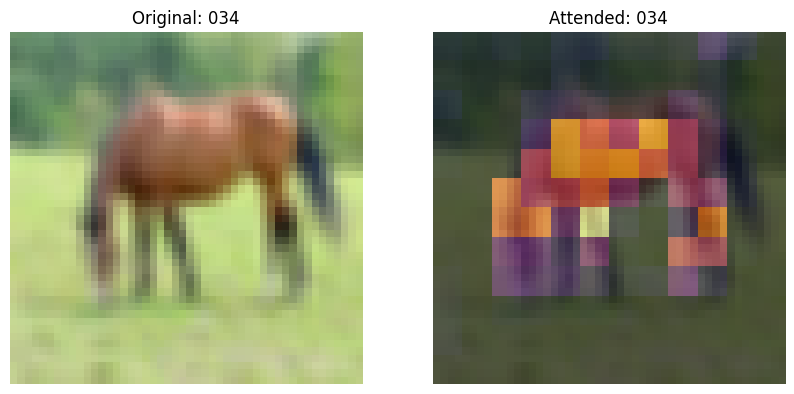

313/313 [==============================] - 33s 106ms/step - loss: 0.1461 - accuracy: 0.9484 - top-5-accuracy: 0.9996 - val_loss: 0.5374 - val_accuracy: 0.8488 - val_top-5-accuracy: 0.9904
Epoch 36/50
313/313 [==============================] - 33s 107ms/step - loss: 0.1397 - accuracy: 0.9522 - top-5-accuracy: 0.9997 - val_loss: 0.5241 - val_accuracy: 0.8572 - val_top-5-accuracy: 0.9906
Epoch 37/50
313/313 [==============================] - 33s 106ms/step - loss: 0.1231 - accuracy: 0.9582 - top-5-accuracy: 0.9997 - val_loss: 0.5136 - val_accuracy: 0.8581 - val_top-5-accuracy: 0.9932
Epoch 38/50
313/313 [==============================] - 33s 106ms/step - loss: 0.1105 - accuracy: 0.9612 - top-5-accuracy: 0.9998 - val_loss: 0.5021 - val_accuracy: 0.8624 - val_top-5-accuracy: 0.9934
Epoch 39/50
313/313 [==============================] - 33s 106ms/step - loss: 0.1077 - accuracy: 0.9624 - top-5-accuracy: 0.9999 - val_loss: 0.5577 - val_accuracy: 0.8535 - val_top-5-accuracy: 0.9923
Epoch 40/50


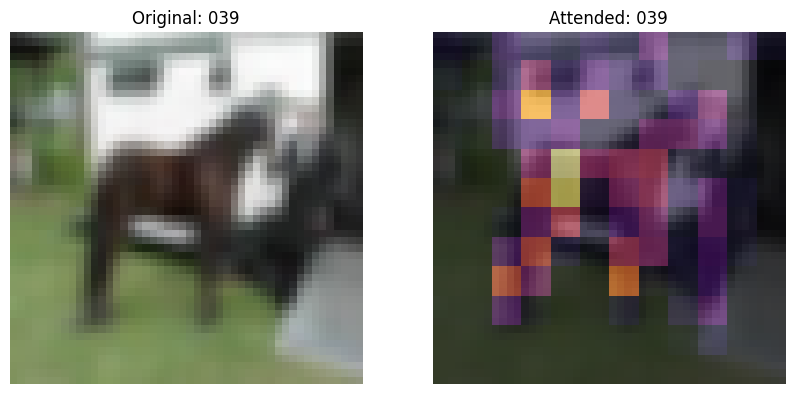

313/313 [==============================] - 33s 107ms/step - loss: 0.0981 - accuracy: 0.9658 - top-5-accuracy: 0.9998 - val_loss: 0.5071 - val_accuracy: 0.8634 - val_top-5-accuracy: 0.9920
Epoch 41/50
313/313 [==============================] - 33s 107ms/step - loss: 0.0851 - accuracy: 0.9710 - top-5-accuracy: 0.9998 - val_loss: 0.5250 - val_accuracy: 0.8629 - val_top-5-accuracy: 0.9914
Epoch 42/50
313/313 [==============================] - 33s 106ms/step - loss: 0.0836 - accuracy: 0.9711 - top-5-accuracy: 0.9999 - val_loss: 0.5280 - val_accuracy: 0.8615 - val_top-5-accuracy: 0.9921
Epoch 43/50
313/313 [==============================] - 33s 106ms/step - loss: 0.0765 - accuracy: 0.9746 - top-5-accuracy: 0.9998 - val_loss: 0.5086 - val_accuracy: 0.8635 - val_top-5-accuracy: 0.9938
Epoch 44/50
313/313 [==============================] - 33s 106ms/step - loss: 0.0732 - accuracy: 0.9759 - top-5-accuracy: 0.9999 - val_loss: 0.4996 - val_accuracy: 0.8653 - val_top-5-accuracy: 0.9938
Epoch 45/50


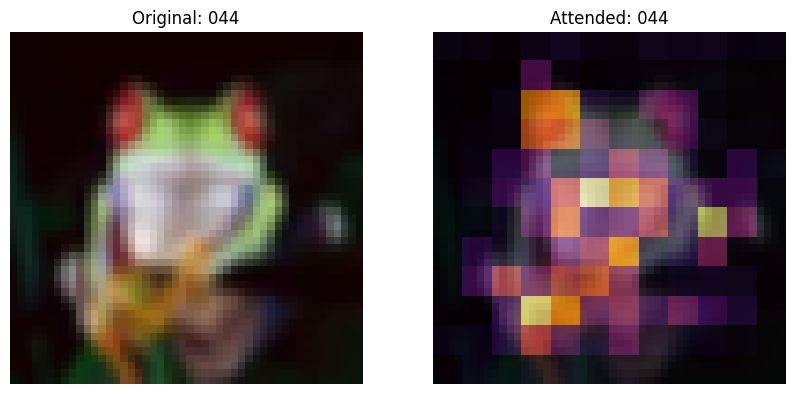

313/313 [==============================] - 34s 107ms/step - loss: 0.0719 - accuracy: 0.9769 - top-5-accuracy: 0.9999 - val_loss: 0.4882 - val_accuracy: 0.8673 - val_top-5-accuracy: 0.9938
Epoch 46/50
313/313 [==============================] - 33s 106ms/step - loss: 0.0784 - accuracy: 0.9754 - top-5-accuracy: 0.9998 - val_loss: 0.4704 - val_accuracy: 0.8648 - val_top-5-accuracy: 0.9935
Epoch 47/50
313/313 [==============================] - 33s 107ms/step - loss: 0.0853 - accuracy: 0.9740 - top-5-accuracy: 0.9996 - val_loss: 0.4553 - val_accuracy: 0.8644 - val_top-5-accuracy: 0.9933
Epoch 48/50
313/313 [==============================] - 33s 106ms/step - loss: 0.1020 - accuracy: 0.9671 - top-5-accuracy: 0.9998 - val_loss: 0.4392 - val_accuracy: 0.8643 - val_top-5-accuracy: 0.9935
Epoch 49/50
313/313 [==============================] - 33s 107ms/step - loss: 0.1273 - accuracy: 0.9613 - top-5-accuracy: 0.9998 - val_loss: 0.4350 - val_accuracy: 0.8592 - val_top-5-accuracy: 0.9934
Epoch 50/50


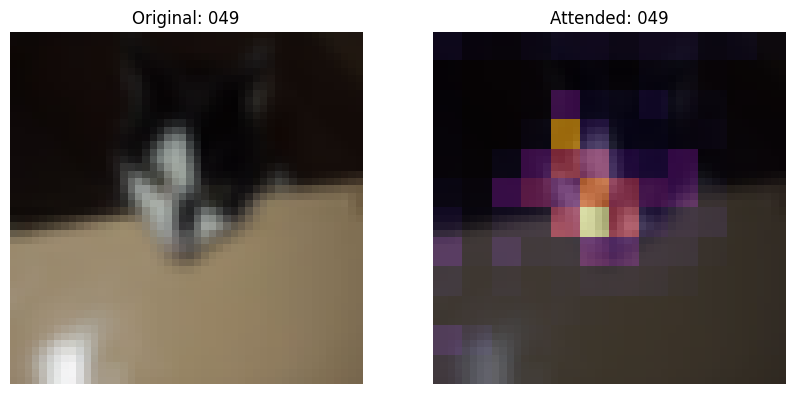

79/79 [==============================] - 2s 31ms/step - loss: 0.4668 - accuracy: 0.8461 - top-5-accuracy: 0.9925
Loss: 0.47
Top 1 test accuracy: 84.61%
Top 5 test accuracy: 99.25%


In [ ]:
train_augmentation_model = get_train_augmentation_model()
preprocessing_model = get_preprocessing()
conv_stem = build_convolutional_stem(dimensions=DIMENSIONS)
conv_trunk = Trunk(depth=TRUNK_DEPTH, dimensions=DIMENSIONS, ratio=SE_RATIO)
attention_pooling = AttentionPooling(dimensions=DIMENSIONS, num_classes=NUM_CLASSES)

patch_convnet = PatchConvNet(
    stem=conv_stem,
    trunk=conv_trunk,
    attention_pooling=attention_pooling,
    train_augmentation_model=train_augmentation_model,
    preprocessing_model=preprocessing_model,
)

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]
# Get the optimizer.
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
# Compile and pretrain the model.
patch_convnet.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
history = patch_convnet.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

# Evaluate the model with the test dataset.
loss, acc_top1, acc_top5 = patch_convnet.evaluate(test_ds)
print(f"Loss: {loss:0.2f}")
print(f"Top 1 test accuracy: {acc_top1*100:0.2f}%")
print(f"Top 5 test accuracy: {acc_top5*100:0.2f}%")

## Inference

Here, we use the trained model to plot the attention map.

   8192/Unknown - 0s 0us/step

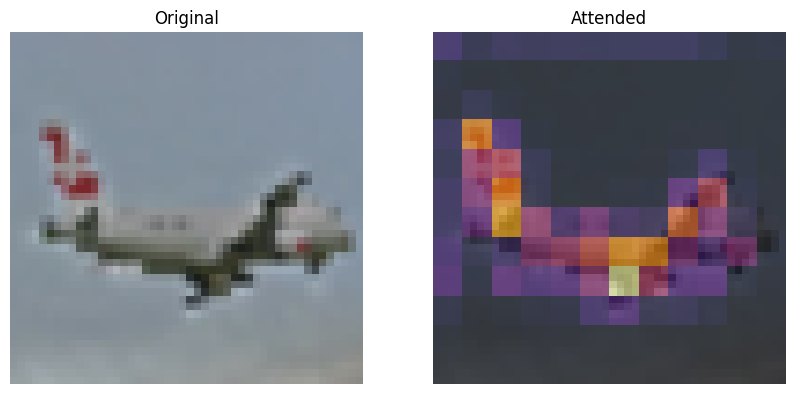

In [ ]:
def plot_attention(image):
    """Plots the attention map on top of the image.

    Args:
        image: A numpy image of arbitrary size.
    """
    # Resize the image to a (32, 32) dim.
    image = tf.image.resize(image, (32, 32))
    image = image[tf.newaxis, ...]
    test_augmented_images = patch_convnet.preprocessing_model(image)
    # Pass through the stem.
    test_x = patch_convnet.stem(test_augmented_images)
    # Pass through the trunk.
    test_x = patch_convnet.trunk(test_x)
    # Pass through the attention pooling block.
    _, test_viz_weights = patch_convnet.attention_pooling(test_x)
    test_viz_weights = test_viz_weights[tf.newaxis, ...]
    # Reshape the vizualization weights.
    num_patches = tf.shape(test_viz_weights)[-1]
    height = width = int(math.sqrt(num_patches))
    test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
    selected_image = test_augmented_images[0]
    selected_weight = test_viz_weights[0]
    # Plot the images.
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(selected_image)
    ax[0].set_title(f"Original")
    ax[0].axis("off")
    img = ax[1].imshow(selected_image)
    ax[1].imshow(selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent())
    ax[1].set_title(f"Attended")
    ax[1].axis("off")
    plt.axis("off")
    plt.show()
    plt.close()


url = "http://farm9.staticflickr.com/8017/7140384795_385b1f48df_z.jpg"
image_name = keras.utils.get_file(fname="image.jpg", origin=url)
image = tf.io.read_file(image_name)
image = tf.io.decode_image(image)
plot_attention(image)

## Conclusions

The attention map corresponding to the trainable `CLASS`
token and the patches of the image helps explain the classificaiton
decision. One should also note that the attention maps gradually get
better. In the initial training regime, the attention is scattered all
around while at a later stage, it focuses more on the objects of the
image.

The non-pyramidal convnet achieves an accuracy of ~84-85% top-1 test
accuracy.

I would like to thank [JarvisLabs.ai](https://jarvislabs.ai/) for
providing GPU credits for this project.

You can try the model on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/patch-conv-net).